In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbbbbbbb/0093.png
/kaggle/input/3d-mnist/voxelgrid.py
/kaggle/input/3d-mnist/train_point_clouds.h5
/kaggle/input/3d-mnist/test_point_clouds.h5
/kaggle/input/3d-mnist/plot3D.py
/kaggle/input/3d-mnist/full_dataset_vectors.h5
/kaggle/input/ssssss/0093.png
/kaggle/input/qqqqqq/Pix2Vox-F-ShapeNet.pth


In [2]:
import torch
import torchvision.models

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        vgg=models.vgg16(pretrained=True)
        print(vgg)
        
        self.vgg=nn.Sequential(*list(vgg.features.children()))[:27]
        

In [65]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
#         self.cfg = cfg

        # Layer Definition
        vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(vgg16_bn.features.children()))[:27]
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=3),
            torch.nn.BatchNorm2d(256),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=4)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, kernel_size=3),
#             torch.nn.Identity(),
            torch.nn.BatchNorm2d(128),
            torch.nn.ELU()
        )

        # Don't update params in VGG16
        for param in vgg16_bn.parameters():
            param.requires_grad = False

    def forward(self, rendering_images):
        
        print(rendering_images.size())  # torch.Size([batch_size, n_views, img_c, img_h, img_w])
        # rendering_images = rendering_images.view(-1, *rendering_images.size()[2:])
        rendering_images=rendering_images.unsqueeze(0)
        rendering_images = rendering_images.permute(1, 0, 2, 3, 4).contiguous()
        # torch.Size([n_views, batch_size, img_c, img_h, img_w])
        rendering_images = torch.split(rendering_images, 1, dim=0)
        image_features = []

        for img in rendering_images:
            features = self.vgg(img.squeeze(dim=0))
            # print(features.size())    # torch.Size([batch_size, 512, 28, 28])
            features = self.layer1(features)
            # print(features.size())    # torch.Size([batch_size, 512, 28, 28])
            features = self.layer2(features)
            # print(features.size())    # torch.Size([batch_size, 256, 6, 6])
            features = self.layer3(features)
            # print(features.size())    # torch.Size([batch_size, 128, 4, 4])
            image_features.append(features)

        image_features = torch.stack(image_features).permute(1, 0, 2, 3, 4).contiguous()
        # print(image_features.size())  # torch.Size([batch_size, n_views, 128, 4, 4])
        return image_features



In [5]:
import cv2 as cv

In [52]:
img=cv.imread("/kaggle/input/bbbbbbbb/0093.png")
img=cv.resize(img,(224,224))
img=torch.from_numpy(img).float().view(-1,224,224)
img=img.unsqueeze(0)

In [66]:
encoder=Encoder()

In [67]:
out_encoder=encoder(img)

torch.Size([1, 3, 224, 224])


In [55]:
out_encoder.shape

torch.Size([1, 1, 128, 4, 4])

In [24]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 8, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(8, 1, kernel_size=1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, image_features):
        # [1, 1, 128, 6, 6]
        image_features = image_features.permute(1, 0, 2, 3, 4).contiguous()
        image_features = torch.split(image_features, 1, dim=0)
        gen_volumes = []
        raw_features = []

        for features in image_features:
            print(features.shape)
            gen_volume = features.view(-1, 256, 2, 2, 2)
#             gen_volume = features.view(-1, 128, 6, 6, 1)
            # print(gen_volume.size())   # torch.Size([batch_size, 156, 2, 2, 2])
            gen_volume = self.layer1(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 128, 4, 4, 4])
            gen_volume = self.layer2(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 64, 8, 8, 8])
            gen_volume = self.layer3(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 32, 16, 16, 16])
            gen_volume = self.layer4(gen_volume)
            raw_feature = gen_volume
            # print(gen_volume.size())   # torch.Size([batch_size, 8, 32, 32, 32])
            gen_volume = self.layer5(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 1, 32, 32, 32])
            raw_feature = torch.cat((raw_feature, gen_volume), dim=1)
            # print(raw_feature.size())  # torch.Size([batch_size, 9, 32, 32, 32])

            gen_volumes.append(torch.squeeze(gen_volume, dim=1))
            raw_features.append(raw_feature)
        
        gen_volumes = torch.stack(gen_volumes).permute(1, 0, 2, 3, 4).contiguous()
        raw_features = torch.stack(raw_features).permute(1, 0, 2, 3, 4, 5).contiguous()
        # print(gen_volumes.size())      # torch.Size([batch_size, n_views, 32, 32, 32])
        # print(raw_features.size())     # torch.Size([batch_size, n_views, 9, 32, 32, 32])
        return raw_features, gen_volumes

In [68]:
decoder=Decoder()

In [56]:
raw_features, generated_volume=decoder(out_encoder)

torch.Size([1, 1, 128, 4, 4])


In [57]:
generated_volume.shape

torch.Size([1, 1, 32, 32, 32])

In [ ]:
generated_volume = torch.mean(generated_volume, dim=0)

In [31]:
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

In [58]:
def get_volume_views(volume):
    volume = volume.squeeze().__ge__(0.5)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # Correct way to set up 3D axes
    ax.set_aspect('equal')
    ax.voxels(volume, edgecolor="k")
    
    # Display the generated plot in the notebook cell output
    plt.show()
    plt.close()

In [59]:
generated_volume[0][0].shape

torch.Size([32, 32, 32])

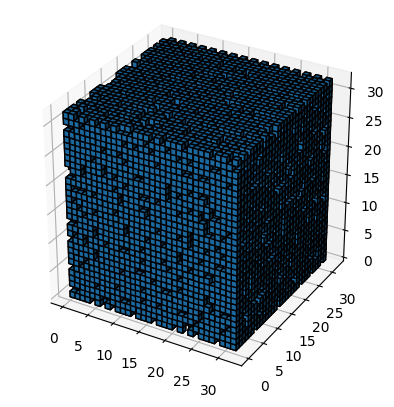

In [60]:
# Detach the tensor from the computation graph and convert it to a NumPy array
gv = generated_volume[0][0].detach().cpu().numpy()

# Display the voxel plot
get_volume_views(gv)

In [38]:
import torch.nn as nn

In [39]:
class model(nn.Module):
    def __init__(self,encoder,decoder):
        super(model,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
    def forward(self,x):
        x=self.encoder(x)
        # x = x.view(-1, 256, 2, 2, 2)
        x=self.decoder(x)
        return x

In [40]:
checkpoint = torch.load("/kaggle/input/qqqqqq/Pix2Vox-F-ShapeNet.pth")

/tmp/ipykernel_36/4220080922.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/qqqqqq/Pix2Vox-F-ShapeNet.pth")


In [41]:
epoch_idx = checkpoint['epoch_idx']
epoch_idx

In [69]:
if torch.cuda.is_available():
    encoder = torch.nn.DataParallel(encoder).cuda()
    decoder = torch.nn.DataParallel(decoder).cuda()

In [64]:
encoder

DataParallel(
  (module): Encoder(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [70]:
encoder.load_state_dict(checkpoint['encoder_state_dict'])

<All keys matched successfully>

In [71]:
decoder.load_state_dict(checkpoint['decoder_state_dict'])

<All keys matched successfully>

In [72]:
Model = model(encoder,decoder)

In [73]:
img=cv.imread("/kaggle/input/bbbbbbbb/0093.png")
img=cv.resize(img,(224,224))
img=torch.from_numpy(img).float().view(-1,224,224)
img=img.unsqueeze(0)

In [74]:
output=Model(img)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 128, 4, 4])


In [80]:
output[1][0][0].shape

torch.Size([32, 32, 32])

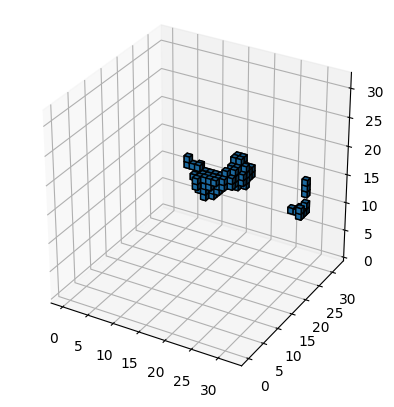

In [81]:
gv = output[1][0][0].detach().cpu().numpy()

# Display the voxel plot
get_volume_views(gv)

In [186]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 4.1 MB/s eta 0:00:00a 0:00:01m
